# Bias

### Goals
In this notebook, you're going to explore a way to identify some biases of a GAN using a classifier, in a way that's well-suited for attempting to make a model independent of an input. Note that not all biases are as obvious as the ones you will see here.

### Learning Objectives
1.  Be able to distinguish a few different kinds of bias in terms of demographic parity, equality of odds, and equality of opportunity (as proposed [here](http://m-mitchell.com/papers/Adversarial_Bias_Mitigation.pdf)).
2. Be able to use a classifier to try and detect biases in a GAN by analyzing the generator's implicit associations.


## Challenges

One major challenge in assessing bias in GANs is that you still want your generator to be able to generate examples of different values of a protected class—the class you would like to mitigate bias against. While a classifier can be optimized to have its output be independent of a protected class, a generator which generates faces should be able to generate examples of various protected class values. 

When you generate examples with various values of a protected class, you don’t want those examples to correspond to any properties that aren’t strictly a function of that protected class. This is made especially difficult since many protected classes (e.g. gender or ethnicity) are social constructs, and what properties count as “a function of that protected class” will vary depending on who you ask. It’s certainly a hard balance to strike.

Moreover, a protected class is rarely used to condition a GAN explicitly, so it is often necessary to resort to somewhat post-hoc methods (e.g. using a classifier trained on relevant features, which might be biased itself). 

In this assignment, you will learn one approach to detect potential bias, by analyzing correlations in feature classifications on the generated images. 

## Getting Started

As you have done previously, you will start by importing some useful libraries and defining a visualization function for your images. You will also use the same generator and basic classifier from previous weeks.

#### Packages and Visualization

In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images,
    size per image, and images per row, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### Generator and Noise

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

#### Classifier

In [3]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is your default)
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the classifier: Given an image tensor, 
        returns an n_classes-dimension tensor representing classes.
        Parameters:
            image: a flattened image tensor with im_chan channels
        '''
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

## Specifying Parameters
You will also need to specify a few parameters before you begin training:
  *   z_dim: the dimension of the noise vector
  *   batch_size: the number of images per forward/backward pass
  *   device: the device type

In [4]:
z_dim = 64
batch_size = 128
device = 'cuda'

## Train a Classifier (Optional)

You're welcome to train your own classifier with this code, but you are provide a pre-trained one based on this architecture here which you can load and use in the next section. 

In [ ]:
# You can run this code to train your own classifier, but there is a provided pre-trained one 
# If you'd like to use this, just run "train_classifier(filename)"
# To train and save a classifier on the label indices to that filename
def train_classifier(filename):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # You're going to target all the classes, so that's how many the classifier will learn
    label_indices = range(40)

    n_epochs = 3
    display_step = 500
    lr = 0.001
    beta_1 = 0.5
    beta_2 = 0.999
    image_size = 64

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    dataloader = DataLoader(
        CelebA(".", split='train', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True)

    classifier = Classifier(n_classes=len(label_indices)).to(device)
    class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
    criterion = nn.BCEWithLogitsLoss()

    cur_step = 0
    classifier_losses = []
    # classifier_val_losses = []
    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for real, labels in tqdm(dataloader):
            real = real.to(device)
            labels = labels[:, label_indices].to(device).float()

            class_opt.zero_grad()
            class_pred = classifier(real)
            class_loss = criterion(class_pred, labels)
            class_loss.backward() # Calculate the gradients
            class_opt.step() # Update the weights
            classifier_losses += [class_loss.item()] # Keep track of the average classifier loss

            ### Visualization code ###
            if cur_step % display_step == 0 and cur_step > 0:
                class_mean = sum(classifier_losses[-display_step:]) / display_step
                print(f"Step {cur_step}: Classifier loss: {class_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
                sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
                plt.legend()
                plt.show()
                torch.save({"classifier": classifier.state_dict()}, filename)
            cur_step += 1

# Uncomment the last line to train your own classfier - this line will not work in Coursera.
# If you'd like to do this, you'll have to download it and run it, ideally using a GPU.
# train_classifier("filename")

## Loading the Pre-trained Models

You can now load the pre-trained generator (trained on CelebA) and classifier using the following code. If you trained your own classifier, you can load that one here instead. However, it is suggested that you first go through the assignment using the pre-trained one.

In [5]:
import torch
gen = Generator(z_dim).to(device)
gen_dict = torch.load("pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


## Feature Correlation
Now you can generate images using the generator. By also using the classifier, you will be generating images with different amounts of the "male" feature.

You are welcome to experiment with other features as the target feature, but it is encouraged that you initially go through the notebook as is before exploring.

In [6]:
# First you generate a bunch of fake images with the generator
n_images = 256
fake_image_history = []
classification_history = []
grad_steps = 30 # How many gradient steps to take
skip = 2 # How many gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

n_features = len(feature_names)
# Set the target feature
target_feature = "Male"
target_indices = feature_names.index(target_feature)
noise = get_noise(n_images, z_dim).to(device)
new_noise = noise.clone().requires_grad_()
starting_classifications = classifier(gen(new_noise)).cpu().detach()

# Additive direction (more of a feature)
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(new_noise)
    fake_image_history += [fake]
    classifications = classifier(fake)
    classification_history += [classifications.cpu().detach()]
    fake_classes = classifications[:, target_indices].mean()
    fake_classes.backward()
    new_noise.data += new_noise.grad / grad_steps

# Subtractive direction (less of a feature)
new_noise = noise.clone().requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(new_noise)
    fake_image_history += [fake]
    classifications = classifier(fake)
    classification_history += [classifications.cpu().detach()]
    fake_classes = classifications[:, target_indices].mean()
    fake_classes.backward()
    new_noise.data -= new_noise.grad / grad_steps

classification_history = torch.stack(classification_history)

You've now generated image samples, which have increasing or decreasing amounts of the target feature. You can visualize the way in which that affects other classified features. The x-axis will show you the amount of change in your target feature and the y-axis shows how much the other features change, as detected in those images by the classifier. Together, you will be able to see the covariance of "male-ness" and other features.

You are started off with a set of features that have interesting associations with "male-ness", but you are welcome to change the features in `other_features` with others from `feature_names`.

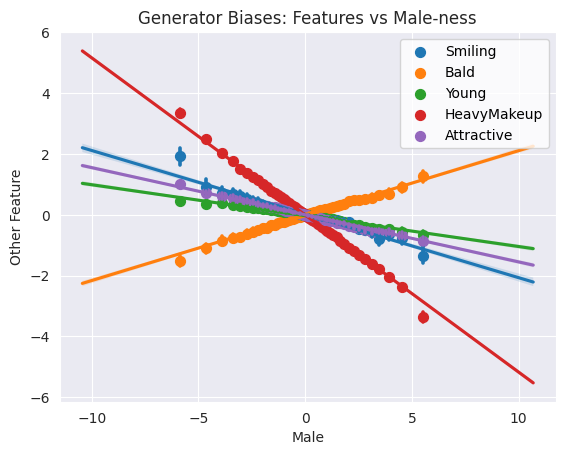

In [7]:
import seaborn as sns
# Set the other features
other_features = ["Smiling", "Bald", "Young", "HeavyMakeup", "Attractive"]
classification_changes = (classification_history - starting_classifications[None, :, :]).numpy()
for other_feature in other_features:
    other_indices = feature_names.index(other_feature)
    with sns.axes_style("darkgrid"):
        sns.regplot(
            x=classification_changes[:, :, target_indices].reshape(-1), 
            y=classification_changes[:, :, other_indices].reshape(-1), 
            fit_reg=True,
            truncate=True,
            ci=99,
            x_ci=99,
            x_bins=len(classification_history),
            label=other_feature
        )
plt.xlabel(target_feature)
plt.ylabel("Other Feature")
plt.title(f"Generator Biases: Features vs {target_feature}-ness")
plt.legend(loc=1)
plt.show()

This correlation detection can be used to reduce bias by penalizing this type of correlation in the loss during the training of the generator. However, currently there is no rigorous and accepted solution for debiasing GANs. A first step that you can take in the right direction comes before training the model: make sure that your dataset is inclusive and representative, and consider how you can mitigate the biases resulting from whatever data collection method you used—for example, getting a representative labelers for your task. 

It is important to note that, as highlighted in the lecture and by many researchers including [Timnit Gebru and Emily Denton](https://sites.google.com/view/fatecv-tutorial/schedule), a diverse dataset alone is not enough to eliminate bias. Even diverse datasets can reinforce existing structural biases by simply capturing common social biases. Mitigating these biases is an important and active area of research.

#### Note on CelebA
You may have noticed that there are obvious correlations between the feature you are using, "male", and other seemingly unrelated features, "smiling" and "young" for example. This is because the CelebA dataset labels had no serious consideration for diversity. The data represents the biases of their labelers, the dataset creators, the social biases as a result of using a dataset based on American celebrities, and many others. Equipped with knowledge about bias, we trust that you will do better in the future datasets you create.

## Quantification
Finally, you can also quantitatively evaluate the degree to which these factors covary. Given a target index, for example corresponding to "male," you'll want to return the other features that covary with that target feature the most. You'll want to account for both large negative and positive covariances, and you'll want to avoid returning the target feature in your list of covarying features (since a feature will often have a high covariance with itself). You'll complete some helper functions first, each of which should be one or two lines long.

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">covariance_matrix_from_examples</font></code></b>
</font>
</summary>

1.   You will likely find the following function useful: [np.cov](https://numpy.org/doc/stable/reference/generated/numpy.cov.html). Note the `rowvar` parameter.
2.   You will probably find it useful to [reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) the input.
</details>

In [23]:
from torch.distributions import MultivariateNormal
def covariance_matrix_from_examples(examples):
    """
    Helper function for get_top_covariances to calculate a covariance matrix. 
    Parameter: examples: a list of steps corresponding to samples of shape (2 * grad_steps, n_images, n_features)
    Returns: the (n_features, n_features) covariance matrix from the examples
    """
    # Hint: np.cov will be useful here - note the rowvar argument!
    ### START CODE HERE ###
    flattened = examples.reshape(-1, examples.shape[-1])
    return np.cov(flattened, rowvar=False)
    ### END CODE HERE ###
mean = torch.Tensor([0, 0, 0, 0]) 
covariance = torch.Tensor( 
    [[10, 2, -0.5, -5],
     [2, 11, 5, 4],
     [-0.5, 5, 10, 2],
     [-5, 4, 2, 11]]
)
samples = MultivariateNormal(mean, covariance).sample((60 * 128,))
foo = samples.reshape(60, 128, samples.shape[-1]).numpy()
assert np.all(np.abs(covariance_matrix_from_examples(foo) - covariance.numpy()) < 0.5)
print("covariance_matrix_from_examples works!")

covariance_matrix_from_examples works!


Now you'll write a helper function to return the indices of a numpy array in order of magnitude.
<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">get_top_magnitude_indices</font></code></b>
</font>
</summary>

4.   Feel free to use any reasonable method to get the largest elements - you may find [np.argsort](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) useful here.
</details>

In [24]:
def get_top_magnitude_indices(values):
    """
    Helper function for get_top_covariances to get indices by magnitude. 
    Parameter: values, a list of values as a numpy array of shape (n_values)
    Returns: numpy array of indices sorted from greatest to least by the magnitudes of their corresponding values
    """
    # Hint: This can be done in one or two lines using np.argsort and np.abs!
    ### START CODE HERE ###
    top_indices = np.argsort(np.abs(values))[::-1]
    ### END CODE HERE ###
    return top_indices
assert get_top_magnitude_indices([3, 2, 1, 0]).tolist() == [0, 1, 2, 3]
assert get_top_magnitude_indices([-2, 0, 1]).tolist() == [0, 2, 1]
print("get_top_magnitude_indices works!")

get_top_magnitude_indices works!


Now you'll write a helper function to return a list with an element removed by the value, in an unchanged order. In this case, you won't have to remove any values multiple times, so don't worry about how you handle multiple examples.

In [25]:
def remove_from_list(indices, index_to_remove):
    """
    Helper function for get_top_covariances to remove an index from an array. 
    Parameter: indices, a list of indices as a numpy array of shape (n_indices)
    Returns: the numpy array of indices in the same order without index_to_remove
    """
    # Hint: There are many ways to do this, but please don't edit the list in-place.
    # If you're not very familiar with array indexing, you may find this page helpful:
    # https://numpy.org/devdocs/reference/arrays.indexing.html (especially boolean indexing)
    ### START CODE HERE ###
    new_indices = np.delete(indices, np.where(indices == index_to_remove))
    ### END CODE HERE ###
    return new_indices
assert remove_from_list(np.array([3, 2, 1, 0]), 1).tolist() == [3, 2, 0]
print("remove_from_list works!")

remove_from_list works!


Now, you can put the above helper functions together.

<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">get_top_covariances</font></code></b>
</font>
</summary>

1.   Start by finding the covariance matrix
3.   The target feature should not be included in the outputs.
5.   It may be easiest to solve this if you find the `relevant_indices` first, and then use `relevant_indices` to calculate `highest_covariances`.
6.   You want to sort by absolute value but return the actual values.
</details>

In [26]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL: get_top_covariances
def get_top_covariances(classification_changes, target_index, top_n=10):
    '''
    Function for getting the top n covariances: Given a list of classification changes
    and the index of the target feature, returns 
    (1) relevant_indices: a list or tensor (numpy or torch) of the indices corresponding 
        to the n features that covary most with the target in terms of absolute covariance
    (2) highest_covariances: a list or tensor of the degrees to which they covary.
    Parameters:
        classification_changes: relative changes in classifications of each generated image 
          resulting from optimizing the target feature (see above for a visualization)
        target_index: the index of the target feature, a scalar
        top_n: the top most number of elements to return, default is 10
    '''
    # Hint: Don't forget you also care about negative covariances!
    # Note that classification_changes has a shape of (2 * grad_steps, n_images, n_features) 
    # where n_features is the number of features measured by the classifier, and you are looking
    # for the covariance of the features based on the (2 * grad_steps * n_images) samples.
    #### START CODE HERE ####
    covariance_matrix = covariance_matrix_from_examples(classification_changes)
    relevant_indices = remove_from_list(get_top_magnitude_indices(covariance_matrix[target_index, :]), target_index)[:top_n]
    highest_covariances = covariance_matrix[:, relevant_indices][target_index]
    #### END CODE HERE ####
    return relevant_indices, highest_covariances

In [27]:
# UNIT TEST
from torch.distributions import MultivariateNormal
mean = torch.Tensor([0, 0, 0, 0]) 
covariance = torch.Tensor( 
    [[10, 2, -0.5, -5],
     [2, 11, 5, 4],
     [-0.5, 5, 10, 2],
     [-5, 4, 2, 11]]
)
independent_dist = MultivariateNormal(mean, covariance)
samples = independent_dist.sample((60 * 128,))
foo = samples.reshape(60, 128, samples.shape[-1])

relevant_indices, highest_covariances = get_top_covariances(foo, 1, top_n=3)
assert (tuple(relevant_indices) == (2, 3, 0)), "Make sure you're getting the greatest, not the least covariances"
assert np.all(np.abs(highest_covariances - [5, 4, 2]) < 0.5 )

relevant_indices, highest_covariances = get_top_covariances(foo, 0, top_n=3)
assert (tuple(relevant_indices) == (3, 1, 2)), "Make sure to consider the magnitude of negative covariances"
assert np.all(np.abs(highest_covariances - [-5, 2, -0.5]) < 0.5 )

relevant_indices, highest_covariances = get_top_covariances(foo, 2, top_n=2)
assert (tuple(relevant_indices) == (1, 3))
assert np.all(np.abs(highest_covariances - [5, 2]) < 0.5 )

relevant_indices, highest_covariances = get_top_covariances(foo, 3, top_n=2)
assert (tuple(relevant_indices) == (0, 1))
assert np.all(np.abs(highest_covariances - [-5, 4]) < 0.5 )

print("All tests passed")

All tests passed


In [29]:

relevant_indices, highest_covariances = get_top_covariances(classification_changes, target_indices, top_n=10)
print(relevant_indices)
assert relevant_indices[9] == 34
assert len(relevant_indices) == 10
assert highest_covariances[8] - (-1.2418) < 1e-3
for index, covariance in zip(relevant_indices, highest_covariances):
    print(f"{feature_names[index]}  {covariance:f}")

[36 18 24 30  0 22 16 38  9 34]


AssertionError: 

One of the major sources of difficulty with identifying bias and fairness, as discussed in the lectures, is that there are many ways you might reasonably define these terms. Here are three ways that are computationally useful and [widely referenced](http://m-mitchell.com/papers/Adversarial_Bias_Mitigation.pdf). They are, by no means, the only definitions of fairness (see more details [here](https://developers.google.com/machine-learning/glossary/fairness)):


1.   Demographic parity: the overall distribution of the predictions made by a predictor is the same for different values of a protected class. 
2.   Equality of odds: all else being equal, the probability that you predict correctly or incorrectly is the same for different values of a protected class. 
2.   Equality of opportunity: all else being equal, the probability that you predict correctly is the same for different valus of a protected class (weaker than equality of odds).

With GANs also being used to help downstream classifiers (you will see this firsthand in future assignments), these definitions of fairness will impact, as well as depend on, your downstream task. It is important to work towards creating a fair GAN according to the definition you choose. Pursuing any of them is virtually always better than blindly labelling data, creating a GAN, and sampling its generations.